# Complaints Analysis using Sentence Transformer

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import re

# For Dataframe optimisation
from typing import List

# NLP Packages
import torch
import nltk
from sentence_transformers import SentenceTransformer

# Set to show all columns and max 50 rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

c:\Users\hjurz\.conda\envs\env_complaints_nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cuda_on = torch.cuda.is_available()

if cuda_on == True:
    use_device = 'cuda'
else:
    use_device = 'cpu'
    print(cuda_on)

print("Device to be used: ", use_device)

Device to be used:  cuda


In [3]:
# First we need to download vader lexocon and stopwords from nltk.
# these will be used in sentiment analysis and removing stopwords from tokens respectively.
# # Only need to be run once.

# nltk.download("vader_lexicon")
# nltk.download("stopwords")

## Read in Data

In [4]:
df = pd.read_csv("Financial_Consumer_Complaints.csv", parse_dates=["Date received"])

In [5]:
data=df.copy()

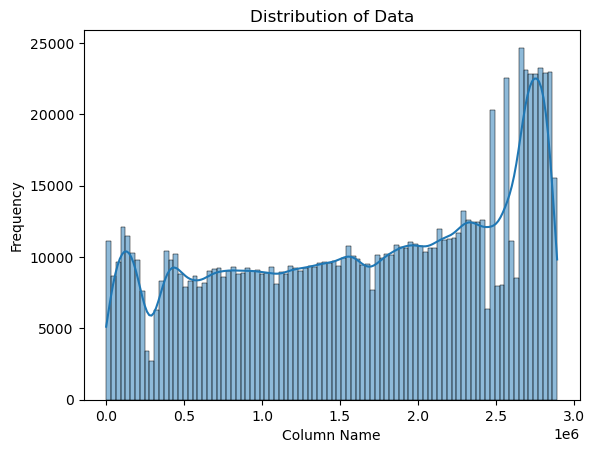

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data into a pandas DataFrame
# data = pd.read_csv('data.csv')

# Plot a histogram with a KDE
sns.histplot(data, x='Complaint ID', kde=True)
plt.title('Distribution of Data')
plt.xlabel('Column Name')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [11]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
0,2014-03-12,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217,NaN
1,2016-10-01,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN
2,2016-10-17,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN
3,2014-06-08,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06-10-2014,Closed with explanation,Yes,Yes,885638,NaN
4,2014-09-13,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760,NaN


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025010 entries, 0 to 1025009
Data columns (total 19 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   Date received                 1025010 non-null  datetime64[ns]
 1   Product                       1025010 non-null  object        
 2   Sub-product                   789840 non-null   object        
 3   Issue                         1025010 non-null  object        
 4   Sub-issue                     528853 non-null   object        
 5   Consumer Complaint            277814 non-null   object        
 6   Company Public Response       318364 non-null   object        
 7   Company                       1025010 non-null  object        
 8   State                         1012650 non-null  object        
 9   ZIP code                      1008292 non-null  object        
 10  Tags                          141588 non-null   object        
 11

## Optimise dataframe types
To improve dataframe processing performance, we will quickly optimise the field types. 

Most of the fields are object type. We want to keep our free text fields "Consumer Complaint" and "Company Publis Respone" as object type so that w can use it for our NLP analysis.
The rest we can convert to category data type.

For this, it is useful to define functions as below:

In [13]:
def optimise_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimise_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimise_objects(df: pd.DataFrame, datetime_features, string_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            if col not in string_features:
                if not (type(df[col][0])==list):
                    num_unique_values = len(df[col].unique())
                    num_total_values = len(df[col])
                    if float(num_unique_values) / num_total_values < 0.5:
                        df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df


def optimise(df: pd.DataFrame, datetime_features, string_features: List[str] = []):
    return optimise_floats(optimise_ints(optimise_objects(df, datetime_features, string_features)))

    
# Optimis our dataframe, keeping our free text field as 'string' type.
# df = optimise(df, datetime_features=["Date received "], string_features=["Consumer Complaint", "Company Public Response"])

In [14]:
# Generate data profiling report

# prof = ProfileReport(df)
# prof.to_file(output_file='data_profile.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


In [33]:
len(df)

277814

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025010 entries, 0 to 1025009
Data columns (total 19 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   Date received                 1025010 non-null  datetime64[ns]
 1   Product                       1025010 non-null  object        
 2   Sub-product                   789840 non-null   object        
 3   Issue                         1025010 non-null  object        
 4   Sub-issue                     528853 non-null   object        
 5   Consumer Complaint            277814 non-null   object        
 6   Company Public Response       318364 non-null   object        
 7   Company                       1025010 non-null  object        
 8   State                         1012650 non-null  object        
 9   ZIP code                      1008292 non-null  object        
 10  Tags                          141588 non-null   object        
 11

We can now see that there are some changes that will slightly improve performance.
- int64 and float64 have been downcast to int32 and float32 respectively. 
- The two fields we have specified to keep as strings (our free text fields) have been retained as an object, and other have been kept as a category.

The size of the dataframe has also gone from 141 MB to 51 MB

# Data cleaning

Now we will clean the data

In [16]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
0,2014-03-12,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217,NaN
1,2016-10-01,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN
2,2016-10-17,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN
3,2014-06-08,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06-10-2014,Closed with explanation,Yes,Yes,885638,NaN
4,2014-09-13,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760,NaN


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025010 entries, 0 to 1025009
Data columns (total 19 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   Date received                 1025010 non-null  datetime64[ns]
 1   Product                       1025010 non-null  object        
 2   Sub-product                   789840 non-null   object        
 3   Issue                         1025010 non-null  object        
 4   Sub-issue                     528853 non-null   object        
 5   Consumer Complaint            277814 non-null   object        
 6   Company Public Response       318364 non-null   object        
 7   Company                       1025010 non-null  object        
 8   State                         1012650 non-null  object        
 9   ZIP code                      1008292 non-null  object        
 10  Tags                          141588 non-null   object        
 11

Determine which field as comments

In [18]:
df["Consumer Complaint"].head()

0                                                  NaN
1    I have outdated information on my credit repor...
2    I purchased a new car on XXXX XXXX. The car de...
3                                                  NaN
4                                                  NaN
Name: Consumer Complaint, dtype: object

In [19]:
# Drop rows with null in consumer complaint
df = df[df["Consumer Complaint"].notnull()].reset_index()

In [20]:
df.head()

,index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
0,1,2016-10-01,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN
1,2,2016-10-17,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN
2,7,2015-06-15,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,Company chooses not to provide a public response,Experian Information Solutions Inc.,VA,224XX,NaN,Consent provided,Web,06/15/2015,Closed with explanation,Yes,No,1420702,NaN
3,12,2016-02-03,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,NaN,"The CBE Group, Inc.",TX,752XX,NaN,Consent provided,Web,02-03-2016,Closed with explanation,Yes,Yes,1772196,NaN
4,16,2016-02-17,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,Company has responded to the consumer and the ...,SQUARETWO FINANCIAL CORPORATION,NE,693XX,NaN,Consent provided,Web,03-04-2016,Closed with explanation,Yes,Yes,1790634,NaN


# Language Processing

###  Get sentiment score using nltk sentiment analyser

In [21]:
# First we need to download vader lexocon and stopwords from nltk.
# these will be used in sentiment analysis and removing stopwords from tokens respectively.
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hjurz\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hjurz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Get sentiment score using nltk sentiment analyser

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(sent):
    # Sentiment score between 0 and 1
    polarity = sia.polarity_scores(sent)["compound"]
    return(polarity)

# Process dataframe through sentiment score
df["Sentiment"] = df["Consumer Complaint"].apply(get_sentiment_score)

In [23]:
df.head()

,index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18,Sentiment
0,1,2016-10-01,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN,0.4215
1,2,2016-10-17,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN,-0.0688
2,7,2015-06-15,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,Company chooses not to provide a public response,Experian Information Solutions Inc.,VA,224XX,NaN,Consent provided,Web,06/15/2015,Closed with explanation,Yes,No,1420702,NaN,-0.9786
3,12,2016-02-03,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,NaN,"The CBE Group, Inc.",TX,752XX,NaN,Consent provided,Web,02-03-2016,Closed with explanation,Yes,Yes,1772196,NaN,-0.6124
4,16,2016-02-17,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,Company has responded to the consumer and the ...,SQUARETWO FINANCIAL CORPORATION,NE,693XX,NaN,Consent provided,Web,03-04-2016,Closed with explanation,Yes,Yes,1790634,NaN,0.9428


We can see that we now have a sentiment column.

## Clean Text field

### First clean invalid characters using regex

In [24]:
def clean_comment_text(temp):
    """Perform comment cleaning on input"""
    
    # Regex definitions
    remove_punc_regex = r'[^\w#@_]+' # remove punctuation except @#_
    hyper_link_regex = r'https\S+' # Remove hyper links
    crrpt_hyper_link_regex = r'(https)+' # Remove corrupt hyperlinks
    remove_RT_tag_regex = r'(RT|retweet|from|via)((?:)\b\W*@(\w+).)+' #remove retweets
    remove_corrupt_regex = r'[^a-zA-Z0-9-#@\s]+' # Remove corrupted characters
    remove_dup_spc_regex = r'\s+' # ensure only whitespace is a space between tokens
    remove_masking_regex = r'X+'

    # define list of regex to iterate through. Comment out regex to test impact
    regex_list = [hyper_link_regex,
                  remove_punc_regex,
                  remove_RT_tag_regex,
                  remove_corrupt_regex,
                  remove_dup_spc_regex,
                  remove_masking_regex]
    
    # Remove apostrophes to ensure words like it's not converted to it s
    temp = temp.replace("'", "")
    
    # Iterate through each regex and apply. Replace with space to ensure words are not joined
    for regex in regex_list:
        temp = re.sub(regex, " ", temp)
        
    # Remove leading and trailing whitespace
    temp = temp.strip()
    
    # Make comment lowercase
    temp = temp.lower()
    
    return temp

# Apply to our data
df["Complaint_Clean"] = df["Consumer Complaint"].apply(clean_comment_text)

## Tokenise comments

In [25]:
# Tokenise
from nltk import TweetTokenizer
tt = TweetTokenizer()

# Apply to data
df["Token_List"] = df["Complaint_Clean"].apply(tt.tokenize)

## Remove stopwords

In [26]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.append("00")

def remove_stopwords(tokens):
    # Remove stopwords using list comprehension
    stopwords_removed = [word for word in tokens if word not in stopwords]
    return stopwords_removed

# Apply to data
df["Token_no_Stopword"] = df["Token_List"].apply(remove_stopwords)

In [27]:
df["Token_no_Stopword"].head()

0    [outdated, information, credit, report, previo...
1    [purchased, new, car, car, dealer, called, cit...
2    [account, credit, report, mistaken, date, mail...
3    [company, refuses, provide, verification, vali...
4    [complaint, regards, square, two, financial, r...
Name: Token_no_Stopword, dtype: object

In [28]:
def flatten_list(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

In [29]:
from collections import Counter
# List all tokens post removed
cur_tkn_list = flatten_list(df["Token_no_Stopword"].values.tolist())
stm_vcb = len(str(cur_tkn_list))

# now check for top 50 tokens
vocab = Counter(cur_tkn_list)
for tkn, frequency in vocab.most_common(50):
    print("------------------------------------------------------------------")
    print("Token: " + tkn + " which occurs " + str(frequency) + " times.")

------------------------------------------------------------------
Token: credit which occurs 406424 times.
------------------------------------------------------------------
Token: account which occurs 343063 times.
------------------------------------------------------------------
Token: would which occurs 193990 times.
------------------------------------------------------------------
Token: loan which occurs 189409 times.
------------------------------------------------------------------
Token: payment which occurs 185110 times.
------------------------------------------------------------------
Token: report which occurs 166881 times.
------------------------------------------------------------------
Token: information which occurs 160302 times.
------------------------------------------------------------------
Token: bank which occurs 154569 times.
------------------------------------------------------------------
Token: debt which occurs 147802 times.
----------------------------

In [30]:
# Test for odd tokens
token = "00"
df_token_test = df[df["Complaint_Clean"].str.contains(token)].reset_index()

# for i in range(5):
#     print(df_token_test["Complaint_Clean"][i], "\n")

In [ ]:
model_large = SentenceTransformer("all-mpnet-base-v2")

# Sentence Transformer Embedding

In [31]:
# Takes 16 minutes to run
model = SentenceTransformer('all-MiniLM-L6-v2')

input = df["Consumer Complaint"]
embeddings = model.encode(input, show_progress_bar=True, device=use_device)
#print(embeddings) 

Batches: 100%|██████████| 8682/8682 [15:50<00:00,  9.13it/s]


In [32]:
# Takes 23 minutes to run
model_large = SentenceTransformer("all-mpnet-base-v2")

embeddings_large = model.encode(input, show_progress_bar=True, device=use_device)
#print(embeddings)

Batches: 100%|██████████| 8682/8682 [20:45<00:00,  6.97it/s]   


# Clustering Model

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [43]:
# Standard scale embedding
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(embeddings))
# X_scaled.columns = embedding.columns

In [44]:
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0,-0.496130,0.339932,-0.894838,1.948047,0.285874,1.456515,-1.903051,-0.842543,-2.290519,0.379915,-0.431774,0.604565,-0.075592,0.549260,-1.230074,-0.470179,0.608771,-0.046022,1.115835,-1.488673,0.089731,0.317899,0.172218,0.429838,1.936239,-0.618594,0.116806,1.448851,-1.175585,-0.036811,-0.491481,1.740739,0.863106,1.054651,-0.627887,-0.531658,1.143041,2.501381,1.201656,1.352351,-0.169284,0.268851,0.675002,-1.314628,-0.241223,1.469806,-1.209419,-1.415467,0.241215,0.775294,-1.461613,-0.341965,0.158794,-0.524853,-0.969968,-1.270652,-0.527022,0.921230,-1.433193,0.325072,0.173476,0.622106,0.157516,-0.284065,-0.116040,-0.676651,0.857096,0.426820,-0.448235,0.387572,-1.955011,0.749522,-1.876143,-0.460480,-0.555077,0.133225,-0.641584,0.082740,-0.558623,-0.867450,0.216586,1.252872,-0.603273,0.373880,-0.811745,-1.369017,0.732990,0.301413,-1.465653,-1.193850,0.096294,-1.048708,1.878675,0.380339,1.107846,-1.085230,-1.176235,-0.731881,1.195282,0.115629,-0.460833,0.718624,-1.803560,1.047688,-0.606497,0.017880,-0.700126,1.350145,-0.851041,0.468369,1.753260,-0.022710,-1.276528,-1.063468,0.043027,-0.279846,0.336874,1.474845,-1.211320,1.457197,-1.438694,0.148697,0.703976,1.192454,-0.582321,-0.715366,0.640915,-0.542000,-0.410702,-0.696243,0.087090,0.825706,-0.994455,1.431616,-0.784398,-0.820660,0.210275,-0.990083,1.713205,0.920148,-1.809610,-1.375218,0.584146,2.131952,-0.631513,1.060952,0.719489,-1.698094,1.481502,-0.550818,-0.649407,-0.636468,1.794671,0.768609,2.321109,1.171905,-1.403547,-1.368596,0.045289,0.197716,-0.448289,0.066556,0.523475,0.165008,0.087588,-1.015941,1.783311,0.975236,1.779263,-0.411998,-1.879993,0.369769,1.958555,-1.653582,1.087407,-0.150269,0.461403,0.138752,1.703711,1.428717,-0.355162,-2.008706,-1.784191,-0.705361,1.120612,-0.778410,0.927847,-0.832296,-0.007818,0.212966,-0.720314,-1.423481,0.629819,2.512717,-1.338639,0.343168,-0.141770,-0.494596,0.734714,-0.785146,-0.604960,-0.359818,0.031392,-0.021468,-0.429607,1.320750,-0.840053,-0.259091,1.144911,-1.191504,-0.656594,1.632733,-0.764640,-0.833780,1.315810,0.457486,1.417500,0.816593,1.244559,-0.627521,-1.808252,-0.147446,0.472094,0.781289,-0.983568,0.179509,-0.419239,0.195697,0.064703,-0.290328,-0.683110,0.987052,-0.598535,-0.706130,0.244060,-1.939742,0.960792,-0.781658,0.278016,2.187827,-1.277990,0.816766,-1.261352,1.409106,0.293270,-0.265812,0.093868,-0.023474,0.275452,-0.674424,0.803755,-1.774986,0.120828,0.378572,-1.307577,-0.964205,-0.734876,-1.396246,0.263571,-1.567462,-0.316596,-0.790602,0.235796,0.516542,0.309313,-0.484565,-0.805167,-1.767990,-0.876091,0.700931,0.1965

In [48]:
def run_clustering_model(df_in, embedding, n_clusters):
    """Run clustering model on dataframe df_in, and embedding. Iterate from 1 to n_clusters
    Returns dataframe with added cluster column based on the text contents"""

    df_out = df_in.copy().reset_index()

    # Standard scale embedding
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(embedding))

    # Init K-Means clustering model with max number of clusters set by n_clusters parameter
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        init='k-means++',
        max_iter=50000,
        n_init=500
        )

    # Fit K-Means model to embedding
    pred_y = kmeans.fit_predict(embedding)

    # Join back to the feature dataframe
    cluster = pd.DataFrame(pred_y)
    cluster.columns = ["Cluster"]
    df_out = pd.concat([df_out, cluster], axis=1)

    return df_out, kmeans


In [49]:
complaints_clustered = run_clustering_model(df, embeddings, 5)

KeyboardInterrupt: 